In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

In [64]:
file = '/Users/gbenz/Downloads/tx10pETCCDI_mon_HadGEM3-GC31-LL_historical_r1i1p1f3_b1981-2010_v20190624_185001-201412_v2-0.nc'

In [65]:
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import numpy as np

## Access with Copernicus Data Store API:

#### Objective by Oct. 30 is to have this process begin by retreiving (predefined and approved) ETCCDI data parameters from an API

### Report Metadata from the selected ETTCDI netCDF file:

Move the pg shapefile to the github repo so this can be accessed without references to local paths

In [66]:
import numpy as np
import xarray as xr

variable = 'tx10p'

# Load the NetCDF file
file_path = '/Users/gbenz/Downloads/tx10pETCCDI_mon_HadGEM3-GC31-LL_historical_r1i1p1f3_b1981-2010_v20190624_185001-201412_v2-0.nc'

# Check if the variable appears in the file path
if variable not in file_path:
    raise ValueError(f"STOP!! Before you break the climate '{variable}' does not appear in the file path '{file_path}'.")
else:
    print(f"The variable '{variable}' was found in the file path and the world continues to spin.")

# Open the dataset
ds = xr.open_dataset(file_path)

# Get latitude and longitude coordinates
lat = ds['lat'].values
lon = ds['lon'].values

# Get the spatial extent (bounding box)
lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()

print(f"Original Latitude range: {lat_min} to {lat_max}")
print(f"Original Longitude range: {lon_min} to {lon_max}")

# Adjust the longitude values from [0°, 360°] to [-180°, 180°]
adjusted_lon = np.where(lon > 180, lon - 360, lon)

# Update the longitude in the dataset
ds = ds.assign_coords(lon=adjusted_lon)

# Sort the dataset by the updated longitude values to maintain spatial continuity
ds = ds.sortby('lon')

# Print the new longitude range
lon_min, lon_max = ds['lon'].min().values, ds['lon'].max().values
print(f"Adjusted Longitude range: {lon_min} to {lon_max}")

# Calculate latitude and longitude resolution (difference between adjacent points)
lat_res = lat[1] - lat[0]
lon_res = adjusted_lon[1] - adjusted_lon[0]

print(f"Latitude resolution: {lat_res}")
print(f"Longitude resolution: {lon_res}")

# Get global attributes of the dataset
global_attrs = ds.attrs

# Print the global metadata
print("Global Metadata:")
for key, value in global_attrs.items():
    print(f"{key}: {value}")

# Extract unique years and months using cftime attributes
unique_years = sorted(set(ds['time.year'].values))
unique_months = sorted(set(ds['time.month'].values))

print("Unique Years:", unique_years)
print("Unique Months:", unique_months)

# Now apply the transformation to the variable of interest, e.g., tx10pETCCDI
raster_data = ds['tx10pETCCDI'].isel(time=0)  # Adjust time index as necessary

# Further processing or saving the adjusted dataset if necessary
# For example, saving the dataset back to a new NetCDF file with adjusted longitudes
output_path = '/Users/gbenz/Downloads/adjusted_tx10pETCCDI.nc'
ds.to_netcdf(output_path)

print(f"Adjusted dataset saved to: {output_path}")


The variable 'tx10p' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 08:58:40 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-19491230.nc tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500101-20141230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-20141230.nc
2019-06-19T11:16:23Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2019-06-19T11:07:16Z MIP Convert v1.1.0, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: n

### Load the PG shapefile 
#### Identify the spatial bounds of the PG Extent
#### Tasks to complete ---
Move the pg shapefile to the github repo so this can be accessed without references to local paths

In [45]:
import geopandas as gpd

# Path to your shapefile (replace with the actual path to your shapefile)
shapefile_path = '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)
gdf = gdf[['gid', 'geometry', 'xcoord', 'ycoord']]

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Get the bounding box of the shapefile
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

print(f"Shapefile bounds: {bounds}")

      gid                                           geometry  xcoord  ycoord
0  190494  POLYGON ((26.50000 42.00000, 26.50000 42.50000...   26.75   42.25
1  190495  POLYGON ((27.00000 42.00000, 27.00000 42.50000...   27.25   42.25
2  190496  POLYGON ((27.50000 42.00000, 27.50000 42.50000...   27.75   42.25
3  190507  POLYGON ((33.00000 42.00000, 33.00000 42.50000...   33.25   42.25
4  190508  POLYGON ((33.50000 42.00000, 33.50000 42.50000...   33.75   42.25


create a more general function that subsets data by both year and month. This function can then be easily adapted to loop over a range of years and months for further analysis.

Here's an approach that will work regardless of whether the time format is standard or uses cftime.

In [55]:
# Extract the corresponding year from the time coordinate
time_index = 0

date_time = str(ds['time'].isel(time=time_index).values.item())  # Converts to a scalar value
year = date_time.split('-')[0]
month = date_time.split('-')[1]

# Print the raster data and year
#print("Raster Data:")
#print(raster_data)
print("Year:", date_time)

print(type(date_time))
print(year)
print(month)

Year: 1850-01-15 12:00:00
<class 'str'>
1850
01


In [78]:
def find_etccdi_timeindex(specified_year, specified_month, ds):
    """
    Finds the index of a specified month in a specified year in a NetCDF dataset.
    If the exact month is not found, it locates the index of the first month found in that year.

    Parameters:
        specified_year (str): The year to search for (e.g., '1990').
        specified_month (str): The month to search for (e.g., '01' for January).
        ds: The NetCDF dataset to search through.

    Returns:
        None
    """
    # Extract the time coordinate
    time_values = ds['time'].values  # Get the time coordinate values
    # Convert to string format to extract year and month
    time_strings = [str(t) for t in time_values]

    # Initialize variables to track indices and found months
    specified_month_index = None
    first_month_index = None

    # Search for any month in the specified year
    for idx, date in enumerate(time_strings):
        year, month, _ = date.split('-')  # Split to get year and month
        if year == specified_year:
            # Track the first month found
            if first_month_index is None:
                first_month_index = idx
            
            # Check for the specified month
            if month == specified_month:
                specified_month_index = idx  # Store the specified month index
                break  # Break immediately if specified month is found

    # Validate the results
    if specified_month_index is not None:
        # Confirm that the index corresponds to the specified month
        year_check, month_check, _ = time_strings[specified_month_index].split('-')
        print(f"Index of {specified_month} data for year {specified_year}: {specified_month_index}")
        print(f"Validation: Found data for Year: {year_check}, Month: {month_check} at index {specified_month_index}.")
        return(specified_month_index)
    else:
        # If the specified month data is not found, check if any month data exists
        if first_month_index is not None:
            print(f"No data found for {specified_month} of the year {specified_year} but located data for the first available month.")
            # Validate the first month found
            year_check, month_check, _ = time_strings[first_month_index].split('-')
            print(f"Validation: Found data for Year: {year_check}, Month: {month_check} at index {first_month_index}.")
            return(first_month_index)

        else:
            print(f"No data found for the year {specified_year}.")
            return(None)


# Example usage:
# find_month_index('1990', '01', ds)  # Searching for January 1990


In [82]:
#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '1995'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '2000'
end_month = '12'
#-----------------------------------------------------------
#-----------------------------------------------------------
# Establish Start and End index values:
start_index_val =  find_etccdi_timeindex(start_year, start_month, ds)
end_index_val = find_etccdi_timeindex(end_year, end_month, ds)
#-----------------------------------------------------------
print(f'The start index is: {start_index_val}')
print(f'The end index is: {end_index_val}')
#-----------------------------------------------------------
index_list = list(range(start_index_val, end_index_val + 1))
#-----------------------------------------------------------

Index of 01 data for year 1995: 1740
Validation: Found data for Year: 1995, Month: 01 at index 1740.
Index of 12 data for year 2000: 1811
Validation: Found data for Year: 2000, Month: 12 at index 1811.
The start index is: 1740
The end index is: 1811


### Testing on the first n elements:

In [96]:
sub_index = index_list[:2]

### Puts it all together

Parameters:
1. references the sub_index which supplies the list (or sublist) of indexes to iterate over. Index specifically references time. This can be confusing because the ETCCDI variables are themselves climate indices.
2. Creates a single geotiff from the current time selection. We do this because the NetCDF itself is not a format that can be incorporated into rigorous analysis so as we iterate through the time series we convert the working item to a geotiff which is a format that can be operated on.


1740
Year: 1995-01-15 12:00:00
<class 'str'>
1995
01
GeoTIFF saved at: working_etccdi_file.tif
Resampled GeoTIFF saved at: working_etccdi_file_resampled.tif


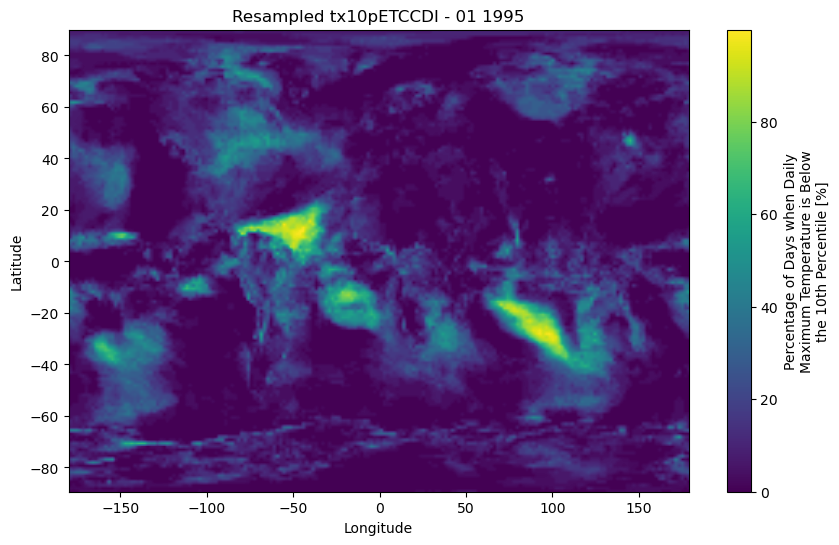

Field names in stats_gdf:
['geometry', 'gid', 'xcoord', 'ycoord', 'mean']
Field names in pg_gdf:
['gid', 'geometry', 'xcoord', 'ycoord']


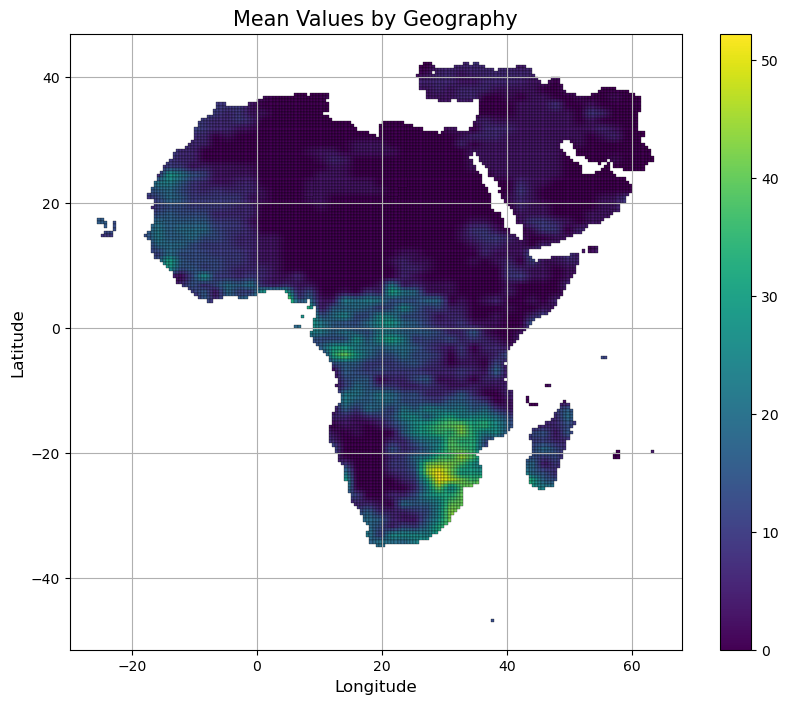

1741
Year: 1995-02-15 12:00:00
<class 'str'>
1995
02
GeoTIFF saved at: working_etccdi_file.tif
Resampled GeoTIFF saved at: working_etccdi_file_resampled.tif


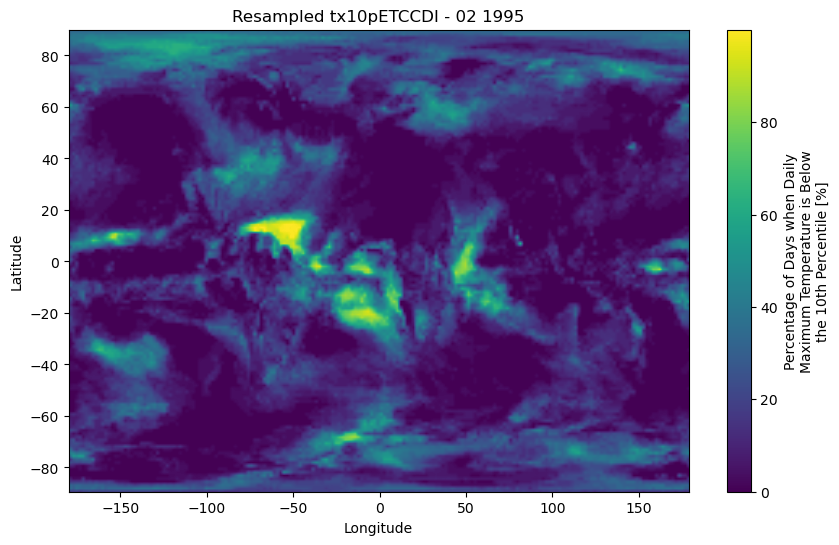

Field names in stats_gdf:
['geometry', 'gid', 'xcoord', 'ycoord', 'mean']
Field names in pg_gdf:
['gid', 'geometry', 'xcoord', 'ycoord']


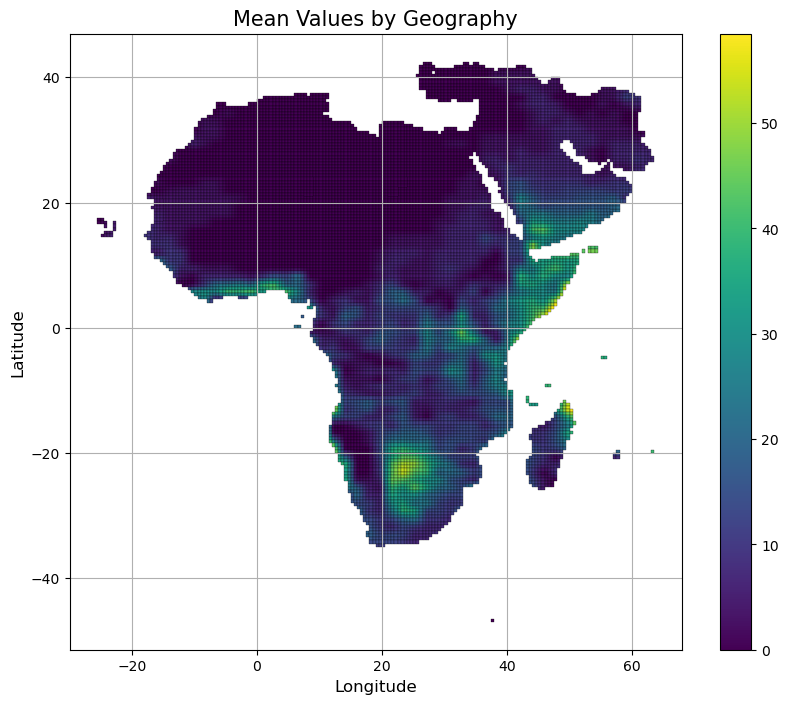

In [101]:
import rioxarray
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os

#----------------------------------------------------------------------------------------------------------
# communicates the range of dates (within the NetCDF File) to loop through
sub_index
#----------------------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------------------
# Create a geotiff that can be read by rioxarray
#----------------------------------------------------------------------------------------------------------

for i in sub_index:
    print(i)

    time_index = i

    raster_data = ds['tx10pETCCDI'].isel(time=time_index)  # Adjust time index as necessary

    date_time = str(ds['time'].isel(time=time_index).values.item())  # Converts to a scalar value
    year = date_time.split('-')[0]
    month = date_time.split('-')[1]

    # Print the raster data and year
    print("Year:", date_time)

    print(type(date_time))
    print(year)
    print(month)

    raster_data = raster_data.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

    # Check if the CRS (Coordinate Reference System) is already defined; if not, set one
    if not raster_data.rio.crs:
        raster_data = raster_data.rio.write_crs("EPSG:4326")  # WGS 84 Geographic Coordinate System

    # Save it as a GeoTIFF
    raster_file_path = 'working_etccdi_file.tif'
    raster_data.rio.to_raster(raster_file_path)

    print(f"GeoTIFF saved at: {raster_file_path}")

#-------------------------------------------------------------------------------------------------------------------------------------
# Resample Raster to new (finer) resolution
#-------------------------------------------------------------------------------------------------------------------------------------

    # Open the saved GeoTIFF
    raster_data = rioxarray.open_rasterio('working_etccdi_file.tif')

    # Ensure the data has the correct CRS and dimensions
    raster_data = raster_data.rio.set_spatial_dims(x_dim='x', y_dim='y')

    # Determine the current resolution
    current_resolution_x = abs(raster_data.x[1] - raster_data.x[0])
    current_resolution_y = abs(raster_data.y[1] - raster_data.y[0])

    # Calculate new resolution (1/10th of original)
    new_resolution_x = current_resolution_x / 10
    new_resolution_y = current_resolution_y / 10

    # Resample the raster data to the new resolution
    resampled_raster = raster_data.rio.reproject(
        raster_data.rio.crs,
        shape=(
            int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
            int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
        ),
        resampling=Resampling.bilinear  # Use the correct resampling method
    )

    # Save the resampled raster to a new GeoTIFF
    resampled_raster_path = 'working_etccdi_file_resampled.tif'
    resampled_raster.rio.to_raster(resampled_raster_path)

    print(f"Resampled GeoTIFF saved at: {resampled_raster_path}")

    # Optionally plot the resampled raster
    plt.figure(figsize=(10, 6))
    resampled_raster.plot(cmap='viridis')  # Change colormap if desired
    plt.title(f"Resampled tx10pETCCDI - {month} {year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------
# Compute Zonal Statistics
#-------------------------------------------------------------------------------------------------------------------------------------
    
    resampled_raster_path = 'working_etccdi_file_resampled.tif'
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf[['gid', 'geometry', 'xcoord', 'ycoord']]

    # Calculate zonal statistics: mean for each shapefile grid cell
    stats = zonal_stats(gdf, resampled_raster_path, stats='mean', geojson_out=True)

    # Convert the stats to a GeoDataFrame
    stats_gdf = gpd.GeoDataFrame.from_features(stats)
    print('Field names in stats_gdf:')
    print(list(stats_gdf))
    print('Field names in pg_gdf:')
    print(list(gdf))

    # Optional: Merge stats with original GeoDataFrame
    #gdf_merged = gdf.merge(stats_gdf[['gid', 'mean']], on='gid', how='left')
    #gdf_merged['geometry'] = gdf_merged['geometry'].combine_first(stats_gdf.set_index('gid')['geometry'])
    gdf_merged = gpd.GeoDataFrame(gdf_merged, geometry='geometry')

#-------------------------------------------------------------------------------------------------------------------------------------
# Produce Visualization (for checks)
#-------------------------------------------------------------------------------------------------------------------------------------

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size as needed

    # Plot the GeoDataFrame
    gdf_merged.plot(column='mean',  # Specify the column to use for coloring
                    ax=ax,         # Use the defined axes
                    legend=True,   # Add a legend
                    cmap='viridis',  # Colormap to use
                    edgecolor='black',  # Edge color of geometries
                    linewidth=0.2)  # Set edge width to 0.2

    # Customize the plot
    ax.set_title('Mean Values by Geography', fontsize=15)  # Title
    ax.set_xlabel('Longitude', fontsize=12)  # X-axis label
    ax.set_ylabel('Latitude', fontsize=12)  # Y-axis label
    ax.grid(True)  # Optional: add a grid

    # Show the plot
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------
# Reformat and save table (at appropriate temporal resolution)
#-------------------------------------------------------------------------------------------------------------------------------------

    #add Year and Month field:
    gdf_merged['year'] = year
    gdf_merged['month'] = month
  
    #rename the mean column to be the name of the climate index:
    
    gdf_merged.rename(columns={'mean': variable}, inplace=True)

    folder = 'etccdi_out_files'

    etccdi_file_name = os.path.join(folder, f"{variable}_{year}_{month}.csv")
    gdf_merged.to_csv(etccdi_file_name)


In [99]:
display(stats_gdf)

,geometry,gid,xcoord,ycoord,mean
0,"POLYGON ((26.50000 42.00000, 26.50000 42.50000...",190494,26.75,42.25,0.000000
1,"POLYGON ((27.00000 42.00000, 27.00000 42.50000...",190495,27.25,42.25,0.144754
2,"POLYGON ((27.50000 42.00000, 27.50000 42.50000...",190496,27.75,42.25,1.154631
3,"POLYGON ((33.00000 42.00000, 33.00000 42.50000...",190507,33.25,42.25,5.338419
4,"POLYGON ((33.50000 42.00000, 33.50000 42.50000...",190508,33.75,42.25,6.372390
...,...,...,...,...,...
13105,"POLYGON ((19.50000 -35.00000, 19.50000 -34.500...",79600,19.75,-34.75,20.025083
13106,"POLYGON ((20.00000 -35.00000, 20.00000 -34.500...",79601,20.25,-34.75,19.357601
13107,"POLYGON ((46.00000 -9.50000, 46.00000 -9.00000...",116373,46.25,-9.25,0.950355
13108,"POLYGON ((46.50000 -9.50000, 46.50000 -9.00000...",116374,46.75,-9.25,2.293102


### Plot that single file:

gdf is a priogrid extent shapefile

Raster Metadata:
{'AREA_OR_POINT': 'Area', 'base_period': '1981-2010', 'cell_measures': 'area: areacella', 'cell_methods': 'area: mean time: maximum', 'comment': "maximum near-surface (usually, 2 meter) air temperature (add cell_method attribute 'time: max')", 'history': 'Created by climdex.pcic 1.1.9.1 on Tue Nov 24 21:15:25 2020', 'long_name': 'Percentage of Days when Daily Maximum Temperature is Below the 10th Percentile', 'original_name': 'mo: (stash: m01s03i236, lbproc: 8192)', 'units': '%', '_FillValue': 1e+20, 'scale_factor': 1.0, 'add_offset': 0.0}


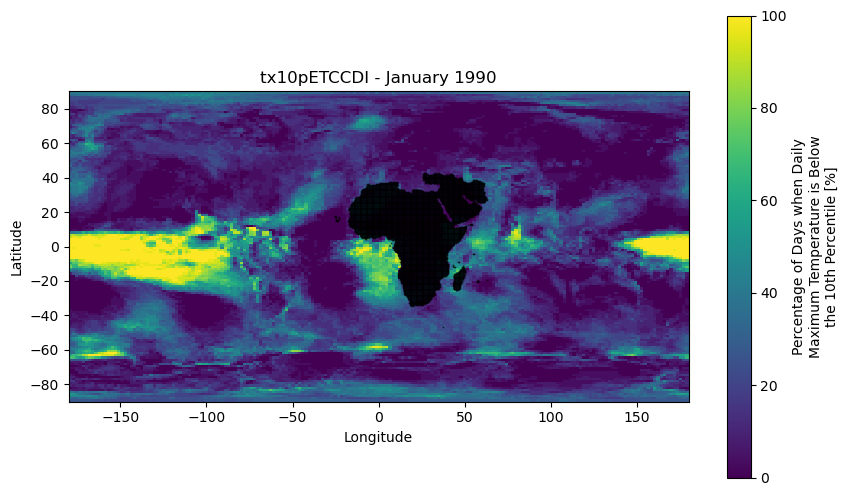

In [26]:
import rioxarray
import matplotlib.pyplot as plt

# Open the saved GeoTIFF
raster_data = rioxarray.open_rasterio('tx10pETCCDI_Jan1990.tif')

# Step 1: Print metadata
print("Raster Metadata:")
print(raster_data.attrs)  # Access attributes directly from the DataArray

# Plot the GeoTIFF data
plt.figure(figsize=(10, 6))
raster_data.plot(cmap='viridis')  # You can change the colormap if desired

# Plot the boundaries of the GeoDataFrame, assuming gdf is defined
gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=.3)

plt.title("tx10pETCCDI - January 1990")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Resample to Fine (Granular) Pixel 

Parameters to consider: 
1. What is an appropriate resolution
2. What is the most appropriate resampling method


Resampled GeoTIFF saved at: tx10pETCCDI_Jan1990_resampled.tif


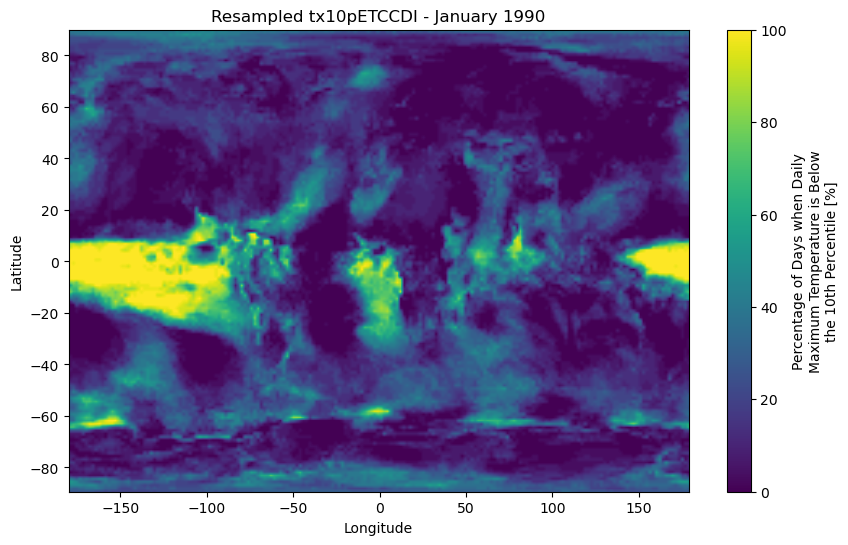

In [28]:
import rioxarray
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

# Open the saved GeoTIFF
raster_data = rioxarray.open_rasterio('tx10pETCCDI_Jan1990.tif')

# Ensure the data has the correct CRS and dimensions
raster_data = raster_data.rio.set_spatial_dims(x_dim='x', y_dim='y')

# Determine the current resolution
current_resolution_x = abs(raster_data.x[1] - raster_data.x[0])
current_resolution_y = abs(raster_data.y[1] - raster_data.y[0])

# Calculate new resolution (1/10th of original)
new_resolution_x = current_resolution_x / 10
new_resolution_y = current_resolution_y / 10

# Resample the raster data to the new resolution
resampled_raster = raster_data.rio.reproject(
    raster_data.rio.crs,
    shape=(
        int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
        int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
    ),
    resampling=Resampling.bilinear  # Use the correct resampling method
)

# Save the resampled raster to a new GeoTIFF
resampled_raster_path = 'tx10pETCCDI_Jan1990_resampled.tif'
resampled_raster.rio.to_raster(resampled_raster_path)

print(f"Resampled GeoTIFF saved at: {resampled_raster_path}")

# Optionally plot the resampled raster
plt.figure(figsize=(10, 6))
resampled_raster.plot(cmap='viridis')  # Change colormap if desired
plt.title("Resampled tx10pETCCDI - January 1990")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Zonal Statistics to Intersect PG extent with ETCCDI Index Value

In [60]:
import geopandas as gpd
from rasterstats import zonal_stats

# Load your shapefile
#shapefile_path = '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp'
#gdf = gpd.read_file(shapefile_path)

# Define the path to the resampled GeoTIFF
resampled_raster_path = 'tx10pETCCDI_Jan1990_resampled.tif'

# Calculate zonal statistics: mean for each shapefile grid cell
stats = zonal_stats(gdf, resampled_raster_path, stats='mean', geojson_out=True)

# Convert the stats to a GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print('Field names in stats_gdf:')
print(list(stats_gdf))
print('Field names in pg_gdf:')
print(list(gdf))

# Optional: Merge stats with original GeoDataFrame
gdf_merged = gdf.merge(stats_gdf[['gid', 'mean']], on='gid', how='left')

#add Year and Month field:
gdf_merged['year'] = year
gdf_merged['month'] = month

# # Print the updated GeoDataFrame with mean statistics
print(gdf_merged[['gid', 'year', 'month', 'mean']])  # Replace with appropriate columns

# # Save the result if needed
# gdf.to_file('zonal_statistics_with_means.shp')


Field names in stats_gdf:
['geometry', 'gid', 'xcoord', 'ycoord', 'mean']
Field names in pg_gdf:
['gid', 'geometry', 'xcoord', 'ycoord']
          gid  year month       mean
0      190494  1850    01   6.922666
1      190495  1850    01   6.996491
2      190496  1850    01   9.038587
3      190507  1850    01  11.211948
4      190508  1850    01  11.211948
...       ...   ...   ...        ...
13105   79600  1850    01  23.021919
13106   79601  1850    01  21.204692
13107  116373  1850    01  41.272418
13108  116374  1850    01  39.732719
13109   62356  1850    01  24.991230

[13110 rows x 4 columns]


This is all sandbox below this -- can delete BS by Nov. 1

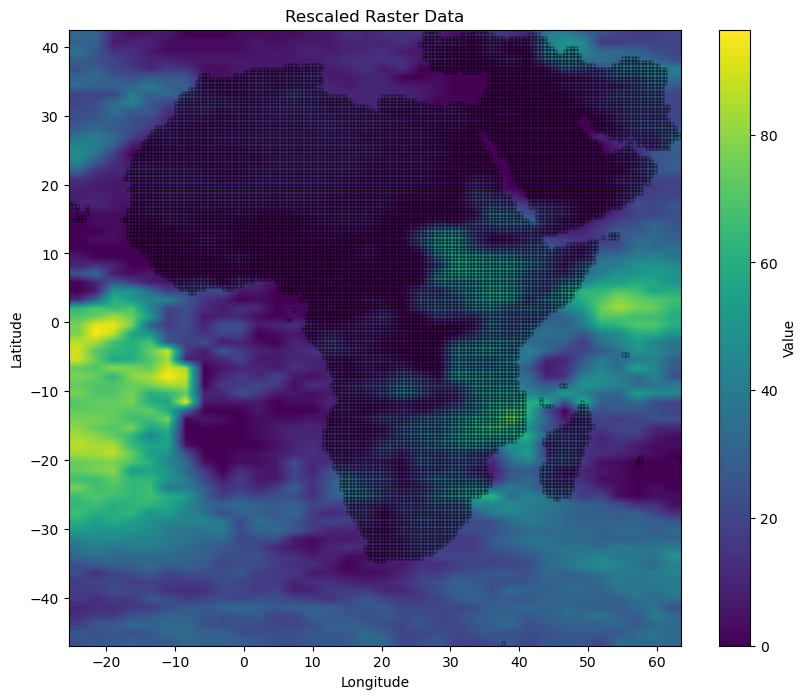

In [46]:
import matplotlib.pyplot as plt
import rasterio

# Define the path to the rescaled raster file
rescaled_raster_path = "rescaled_raster_0.1.tif"

# Open the rescaled raster file
with rasterio.open(rescaled_raster_path) as src:
    # Read the first band of the raster
    data = src.read(1)  # Change index if necessary to read other bands
    transform = src.transform

# Plotting the data
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis', extent=[minx, maxx, miny, maxy], origin='lower')  # Adjust origin to 'upper' or 'lower' based on your data
gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=.3)

plt.colorbar(label='Value')  # Add a colorbar for reference
plt.title('Rescaled Raster Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


GeoDataFrame bounds: [  0.   -47.5   63.75  42.5 ]


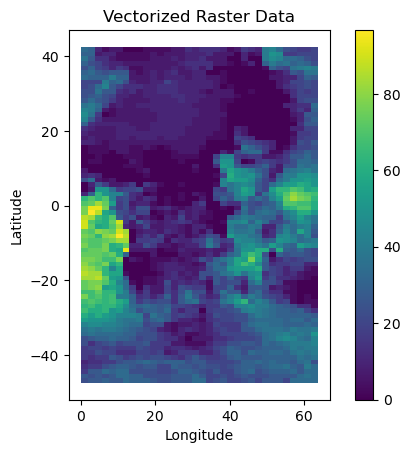

In [20]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# Load the raster dataset
raster_file_path = "tx10pETCCDI_Jan1990.tif"
with rasterio.open(raster_file_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band
    transform = src.transform  # Get the affine transform
    crs = src.crs  # Get the CRS

# Generate polygons from raster cells
mask = raster_data != src.nodata  # Create a mask for valid data
results = shapes(raster_data, mask=mask, transform=transform)

# Create a list to store the shapes and values
polygons = []
values = []

for geom, value in results:
    polygons.append(shape(geom))  # Convert to Shapely geometry
    values.append(value)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs=crs)

# Check the extent of the GeoDataFrame
print("GeoDataFrame bounds:", gdf.total_bounds)

# Save the GeoDataFrame as a new shapefile or GeoPackage
gdf.to_file("vectorized_raster.shp", driver='ESRI Shapefile')

# Optional: Plot the vectorized data
gdf.plot(column='value', legend=True)
plt.title('Vectorized Raster Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [21]:
# Print the bounds of the raster
print("Raster bounds:", (minx, miny, maxx, maxy))

# Print the bounds of the vectorized GeoDataFrame
print("GeoDataFrame bounds:", gdf.total_bounds)


Raster bounds: (-25.500000000199805, -47.000000000399666, 63.50000000000006, 42.499999999700265)
GeoDataFrame bounds: [  0.   -47.5   63.75  42.5 ]


In [22]:
# Load the raster dataset
with rasterio.open(raster_file_path) as src:
    transform = src.transform  # Get the affine transform
    raster_data = src.read(1)  # Read the first band
    nodata_value = src.nodata  # Get nodata value if applicable

# Check the transform details
print("Transform:", transform)

# Check nodata value
print("NoData Value:", nodata_value)


Transform: | 1.88, 0.00, 0.00|
| 0.00, 1.25,-47.50|
| 0.00, 0.00, 1.00|
NoData Value: 1.0000000200408773e+20


In [25]:
# Generate polygons from raster cells
mask = raster_data != nodata_value  # Create a mask for valid data
results = shapes(raster_data, mask=mask, transform=transform)

# Create a list to store the shapes and values
polygons = []
values = []

for geom, value in results:
    polygons.append(shape(geom))  # Convert to Shapely geometry
    values.append(value)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs=src.crs)

# Check the bounds again
print("GeoDataFrame bounds after creation:", gdf.total_bounds)


GeoDataFrame bounds after creation: [  0.   -47.5   63.75  42.5 ]
